### Code Hist.

 - CODE  
    &ensp; : KDHC - Regression - XGBoost  

  - DATE  
    &ensp; 2023-12-06 Created  
    &ensp; 2023-12-07 Lab Updated  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 1) 공통코드 모듈 사용  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 2)    
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 3)   
    
 - DESC  
    &ensp; : Model Analysis - 한국지역난방공사 청주지역 열판매량  
    &emsp; 1) 결측치가 없어서, 그대로 사용  
    &emsp;&ensp;&ensp; (Crawl Code 없음)   
    &emsp; 2)  

 - DATA  
    &emsp; <"Input">  
    1) None (Input Dataset)  
    &emsp;- Period :   
    &emsp;- Interval : 

    &emsp; <"Output">  
    1) -  
    &emsp;- Columns :   
    &emsp;- Period :   
    &emsp;- Interval :  
    
 - Related Link  
    &ensp; 1) XGBoost  
    &ensp;&ensp; https://nicola-ml.tistory.com/99   
    &ensp; 2) XGBoost  
    &ensp;&ensp; https://magoker.tistory.com/106   
    &ensp; 3) Pandas 특정 행  
    &ensp;&ensp; https://www.freecodecamp.org/korean/news/untitled/  

# 01. Code

## 01-01. Init

### 01-01-01. Init_Module Import

In [1]:
#region Basic_Import
## Basic
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import random
from pandas import DataFrame, Series

## Datetime
import time
import datetime as dt
from datetime import datetime, date, timedelta

from glob import glob
import requests
import json

## 시각화
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]

from scipy import stats

## TSNE
from sklearn.datasets import load_digits
from sklearn.manifold import TSNE

## 정규화
from sklearn.preprocessing import MinMaxScaler, StandardScaler

## Modeling, Model Training
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

## Model 평가
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score   # model.score   

## Excel/CSV
import openpyxl, xlrd

import urllib
from urllib.request import urlopen
from urllib.parse import urlencode, unquote, quote_plus

from selenium import webdriver
from selenium.webdriver.chrome.service import Service

from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup

## Init.
pd.options.display.float_format = '{:.10f}'.format
#endregion Basic_Import

In [2]:
## Import_DL
str_tar = "tf"
## For Torch
if str_tar == "torch":
    import torch
    import torch.nn as nn
    from torch.nn.utils import weight_norm
    print("Torch Imported")
## For TF
elif str_tar == "tf":
    import tensorflow as tf
    import tensorflow_addons as tfa
    print("Tensorflow Imported")
else:
    print("Error : Cannot be used except for Keywords")
    print(" : torch / tf")

Tensorflow Imported


In [3]:
## XGBoost
import xgboost as xgb
from xgboost import plot_importance, plot_tree, XGBClassifier

In [4]:
## Import_Local (현재 프로그램에서 미사용)
from DEV_Common_Data_Analysis import print_desc_statistic
from DEV_Common_Data_Datetime import create_col_ymdhm, create_col_datetime, create_df_dt, conv_midnight_24to00, create_col_weekdays #, validate_date, list_invalidDate, calc_df_dt
from DEV_Common_Data_Preprocessing import resample_by_last, find_outlier_Usages, del_outlier_Usages
from DEV_Common_Data_Visualization import visualization_df
from DEV_KASI_Holiday import KASI_holiDay, KASI_restDay, KASI_anniDay
from DEV_KMA_Weather_ASOS import KMA_ASOS_DATA
from DEV_KDHC_Usage import KDHC_HEAT_Usage

### 01-01-02. Config (Directory, Params)

In [5]:
## Init_config
SEED = 42

np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = "1"
random.seed(SEED)

In [6]:
## Define Todate str
str_now_ymd = pd.datetime.now().date()
str_now_y = pd.datetime.now().year
str_now_m = pd.datetime.now().month
str_now_d = pd.datetime.now().day
str_now_hr = pd.datetime.now().hour
str_now_min = pd.datetime.now().minute

print(pd.datetime.now())
print(str(str_now_y) + " / " + str(str_now_m)  + " / " + str(str_now_d))
print(str(str_now_hr) + " : " + str(str_now_min))

2023-12-07 19:10:23.225270
2023 / 12 / 7
19 : 10


## 01-02. Data Load (df_raw)

### 01-02-01. KDHC Heat Usage

In [7]:
# Define data root directory
str_dir_kdhcHeat = "./data_Energy_KDHC_National_Heat/"
print(os.listdir(str_dir_kdhcHeat))

## CSV read
df_kdhc_cj = pd.read_csv(str_dir_kdhcHeat + 'KDHC_HEAT_CHEONGJU_2010_2021_1st_Check.csv')
df_kdhc_cj = df_kdhc_cj.rename(columns = {"HEAT_SELL_DATE" : "METER_DATE"})
df_kdhc_cj["METER_DATE"] = pd.to_datetime(df_kdhc_cj["METER_DATE"])
print(df_kdhc_cj.info())
df_kdhc_cj

['KDHC_COMB_HEAT-CJ_ASOS_KASI_2010-2023.csv', 'KDHC_COMB_HEATxWEATHER_2019-2022.csv', 'KDHC_COMB_HEATxWEATHER_2019-2022_complete_analysis.csv', 'KDHC_COMB_HEATxWEATHER_2019-2022_linearReg.csv', 'KDHC_COMB_HEATxWEATHER_2019-2022_mean_imp.csv', 'KDHC_COMB_KANGNAMHEATxWEATHER_2019-2022.csv', 'KDHC_HEAT', 'KDHC_HEAT.zip', 'KDHC_HEAT_CHEONGJU_2010_2021.csv', 'KDHC_HEAT_CHEONGJU_2010_2021_1st_Check.csv', 'KDHC_HEAT_SEJONG_2014_2018.csv', 'KDHC_HEAT_SEJONG_2014_2018_1st_Check.csv', 'KDHC_NATIONAL_HEAT_hr.csv', 'KDHC_NATIONAL_HEAT_RAW_hr.csv']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105192 entries, 0 to 105191
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   METER_DATE       105192 non-null  datetime64[ns]
 1   DAY_OF_THE_WEEK  105192 non-null  object        
 2   HOUR             105192 non-null  int64         
 3   CHEONGJU         105192 non-null  float64       
 4   YEAR             10

,METER_DATE,DAY_OF_THE_WEEK,HOUR,CHEONGJU,YEAR,MONTH,DAY
0,2010-01-01 01:00:00,금,1,178.0000000000,2010,1,1
1,2010-01-01 02:00:00,금,2,170.0000000000,2010,1,1
2,2010-01-01 03:00:00,금,3,165.0000000000,2010,1,1
3,2010-01-01 04:00:00,금,4,161.0000000000,2010,1,1
4,2010-01-01 05:00:00,금,5,162.0000000000,2010,1,1
...,...,...,...,...,...,...,...
105187,2021-12-31 20:00:00,금,20,217.0000000000,2021,12,31
105188,2021-12-31 21:00:00,금,21,221.0000000000,2021,12,31
105189,2021-12-31 22:00:00,금,22,217.0000000000,2021,12,31
105190,2021-12-31 23:00:00,금,23,214.0000000000,2021,12,31


### 01-02-02. KMA ASOS

In [8]:
# Define data root directory
str_dir_ASOS = "./data_KMA_ASOS/"
print(os.listdir(str_dir_ASOS))

## CSV read
df_asos = pd.read_csv(str_dir_ASOS + 'KMA_ASOS_131_2010-2023_Cleansed_HR.csv'
                      , index_col = 0)
df_asos["METER_DATE"] = pd.to_datetime(df_asos["METER_DATE"])
print(df_asos.info())
df_asos

['ASOS_108_2010.csv', 'ASOS_108_2010_D.csv', 'ASOS_108_2011.csv', 'ASOS_108_2011_D.csv', 'ASOS_108_2012.csv', 'ASOS_108_2012_D.csv', 'ASOS_108_2013.csv', 'ASOS_108_2013_D.csv', 'ASOS_108_2014.csv', 'ASOS_108_2014_D.csv', 'ASOS_108_2015.csv', 'ASOS_108_2015_D.csv', 'ASOS_108_2016.csv', 'ASOS_108_2016_D.csv', 'ASOS_108_2017.csv', 'ASOS_108_2017_D.csv', 'ASOS_108_2018.csv', 'ASOS_108_2018_D.csv', 'ASOS_108_2019.csv', 'ASOS_108_2019_D.csv', 'ASOS_108_2020.csv', 'ASOS_108_2020_D.csv', 'ASOS_108_2021.csv', 'ASOS_108_2021_D.csv', 'ASOS_108_2022.csv', 'ASOS_108_2022_D.csv', 'ASOS_108_2023.csv', 'ASOS_108_2023_D.csv', 'ASOS_119_2010.csv', 'ASOS_119_2010_D.csv', 'ASOS_119_2011.csv', 'ASOS_119_2011_D.csv', 'ASOS_119_2012.csv', 'ASOS_119_2012_D.csv', 'ASOS_119_2013.csv', 'ASOS_119_2013_D.csv', 'ASOS_119_2014.csv', 'ASOS_119_2014_D.csv', 'ASOS_119_2015.csv', 'ASOS_119_2015_D.csv', 'ASOS_119_2016.csv', 'ASOS_119_2016_D.csv', 'ASOS_119_2017.csv', 'ASOS_119_2017_D.csv', 'ASOS_119_2018.csv', 'ASOS_119_

,METER_DATE,temp_outdoor,temp_dew_point,temp_ground,humidity,rainfall,snowfall,snowfall_3hr,wind_speed,wind_direction,pressure_vapor,pressure_area,pressure_sea,sunshine,solar_radiation,cloud_total,cloud_midlow,visual_range
0,2010-01-01 00:00:00,-9.0000000000,-18.0000000000,-8.0000000000,48.0000000000,0.0000000000,0.0000000000,0.0000000000,0.9000000000,320.0000000000,1.5000000000,1016.2000000000,1023.6000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,1800.0000000000
1,2010-01-01 01:00:00,-9.0000000000,-17.3000000000,-7.0000000000,51.0000000000,0.0000000000,0.0000000000,0.0000000000,1.1000000000,250.0000000000,1.6000000000,1016.4000000000,1023.8000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
2,2010-01-01 02:00:00,-9.3000000000,-15.6000000000,-6.1000000000,60.0000000000,0.0000000000,0.0000000000,0.0000000000,0.9000000000,340.0000000000,1.8000000000,1016.6000000000,1024.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
3,2010-01-01 03:00:00,-9.2000000000,-15.5000000000,-6.0000000000,60.0000000000,0.0000000000,0.0000000000,0.0000000000,0.2000000000,0.0000000000,1.8000000000,1016.9000000000,1024.3000000000,0.0000000000,0.0000000000,7.0000000000,7.0000000000,1800.0000000000
4,2010-01-01 04:00:00,-9.7000000000,-15.0000000000,-7.5000000000,65.0000000000,0.0000000000,0.0000000000,0.0000000000,0.5000000000,340.0000000000,1.9000000000,1016.5000000000,1023.9000000000,0.0000000000,0.0000000000,2.0000000000,2.0000000000,1800.0000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5275,2023-08-08 19:00:00,30.6000000000,25.1000000000,30.1000000000,73.0000000000,0.0000000000,0.0000000000,0.0000000000,1.3000000000,50.0000000000,31.9000000000,995.0000000000,1001.5000000000,0.0000000000,0.2800000000,8.0000000000,8.0000000000,3628.0000000000
5276,2023-08-08 20:00:00,30.8000000000,24.4000000000,29.5000000000,69.0000000000,0.0000000000,0.0000000000,0.0000000000,1.1000000000,20.0000000000,30.6000000000,995.5000000000,1002.0000000000,0.0000000000,0.0100000000,8.0000000000,8.0000000000,5000.0000000000
5277,2023-08-08 21:00:00,31.3000000000,22.8000000000,29.1000000000,61.0000000000,0.0000000000,0.0000000000,0.0000000000,1.6000000000,70.0000000000,27.7000000000,995.9000000000,1002.4000000000,0.0000000000,0.0000000000,7.0000000000,7.0000000000,5000.0000000000
5278,2023-08-08 22:00:00,31.0000000000,22.5000000000,28.6000000000,61.0000000000,0.0000000000,0.0000000000,0.0000000000,2.1000000000,70.0000000000,27.2000000000,995.9000000000,1002.4000000000,0.0000000000,0.0000000000,7.0000000000,7.0000000000,5000.0000000000


### 01-02-03. KASI

In [9]:
# Define data root directory
str_dir_KASI = "./data_Date_KASI/"
# print(os.listdir(str_dir_KASI))

## CSV read
df_kasi = pd.read_csv(str_dir_KASI + 'KASI_04-01_holiDay_distAdded_hr.csv')
df_kasi = df_kasi.rename(columns = {"DATETIME" : "METER_DATE"})
df_kasi = df_kasi[['METER_DATE', 'YEAR', 'MONTH', 'DAY', 'code_day_of_the_week', 'dist_from_holiday'
                   , 'HOUR', 'rest_YN']]
print(df_kasi.info())
df_kasi

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122690 entries, 0 to 122689
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   METER_DATE            122690 non-null  object
 1   YEAR                  122690 non-null  int64 
 2   MONTH                 122690 non-null  int64 
 3   DAY                   122690 non-null  int64 
 4   code_day_of_the_week  122690 non-null  int64 
 5   dist_from_holiday     122690 non-null  object
 6   HOUR                  122690 non-null  int64 
 7   rest_YN               122690 non-null  object
dtypes: int64(5), object(3)
memory usage: 7.5+ MB
None


,METER_DATE,YEAR,MONTH,DAY,code_day_of_the_week,dist_from_holiday,HOUR,rest_YN
0,2010-01-01 00:00:00,2010,1,1,4,0,0,1
1,2010-01-01 01:00:00,2010,1,1,4,23,1,0
2,2010-01-01 02:00:00,2010,1,1,4,22,2,0
3,2010-01-01 03:00:00,2010,1,1,4,21,3,0
4,2010-01-01 04:00:00,2010,1,1,4,20,4,0
...,...,...,...,...,...,...,...,...
122685,2023-12-30 20:00:00,2023,12,30,5,0,20,1
122686,2023-12-30 21:00:00,2023,12,30,5,0,21,1
122687,2023-12-30 22:00:00,2023,12,30,5,0,22,1
122688,2023-12-30 23:00:00,2023,12,30,5,0,23,1


### 01-02-04. df_dt

In [10]:
date_kdhc_cj = pd.to_datetime(df_kdhc_cj["METER_DATE"])
dt_kdhc_cj_start = date_kdhc_cj.min()
dt_kdhc_cj_end = date_kdhc_cj.max()
print(dt_kdhc_cj_start)
print(dt_kdhc_cj_end)

date_asos = pd.to_datetime(df_asos["METER_DATE"])
date_asos_start = date_asos.min()
date_asos_end = date_asos.max()
print(date_asos_start)
print(date_asos_end)

date_kasi = pd.to_datetime(df_kasi["METER_DATE"])
date_kasi_start = date_kasi.min()
date_kasi_end = date_kasi.max()
print(date_kasi_start)
print(date_kasi_end)

2010-01-01 01:00:00
2022-01-01 00:00:00
2010-01-01 00:00:00
2023-08-08 23:00:00
2010-01-01 00:00:00
2023-12-31 00:00:00


In [11]:
dt_start = max(dt_kdhc_cj_start, date_asos_start, date_kasi_start)
print(dt_start)
dt_end = max(dt_kdhc_cj_end, date_asos_end, date_kasi_end)
print(dt_end)

2010-01-01 01:00:00
2023-12-31 00:00:00


In [12]:
df_dt = pd.DataFrame()
df_dt = create_df_dt(df_dt, "METER_DATE", dt_start, dt_end, "1H")
df_dt

,METER_DATE,day_of_the_week,YEAR,MONTH,DAY,HOUR,MINUTE,code_day_of_the_week
0,2010-01-01 01:00:00,Friday,2010,1,1,1,0,4
1,2010-01-01 02:00:00,Friday,2010,1,1,2,0,4
2,2010-01-01 03:00:00,Friday,2010,1,1,3,0,4
3,2010-01-01 04:00:00,Friday,2010,1,1,4,0,4
4,2010-01-01 05:00:00,Friday,2010,1,1,5,0,4
...,...,...,...,...,...,...,...,...
122683,2023-12-30 20:00:00,Saturday,2023,12,30,20,0,5
122684,2023-12-30 21:00:00,Saturday,2023,12,30,21,0,5
122685,2023-12-30 22:00:00,Saturday,2023,12,30,22,0,5
122686,2023-12-30 23:00:00,Saturday,2023,12,30,23,0,5


## 01-03. Intergration

In [13]:
df_kdhc_cj = df_kdhc_cj[['METER_DATE', 'YEAR', 'MONTH', 'DAY'
                         , 'HOUR', 'CHEONGJU']]

df_kdhc_cj["METER_DATE"] = pd.to_datetime(df_kdhc_cj["METER_DATE"])
df_asos["METER_DATE"] = pd.to_datetime(df_asos["METER_DATE"])
df_kasi["METER_DATE"] = pd.to_datetime(df_kasi["METER_DATE"])
df_dt["METER_DATE"] = pd.to_datetime(df_dt["METER_DATE"])

df_merge = pd.DataFrame()
df_merge = pd.merge(df_dt, df_kasi
                    , how = 'left', on = ['METER_DATE', 'YEAR', 'MONTH', 'DAY', 'code_day_of_the_week'
                                          , 'HOUR'])
df_merge = pd.merge(df_merge, df_asos
                    , how = 'left', on = ['METER_DATE'])
df_merge = pd.merge(df_merge, df_kdhc_cj
                    , how = 'left', on = ['METER_DATE', 'YEAR', 'MONTH', 'DAY'
                                          , 'HOUR'])
df_merge.columns

Index(['METER_DATE', 'day_of_the_week', 'YEAR', 'MONTH', 'DAY', 'HOUR',
       'MINUTE', 'code_day_of_the_week', 'dist_from_holiday', 'rest_YN',
       'temp_outdoor', 'temp_dew_point', 'temp_ground', 'humidity', 'rainfall',
       'snowfall', 'snowfall_3hr', 'wind_speed', 'wind_direction',
       'pressure_vapor', 'pressure_area', 'pressure_sea', 'sunshine',
       'solar_radiation', 'cloud_total', 'cloud_midlow', 'visual_range',
       'CHEONGJU'],
      dtype='object')

In [14]:
## Export
df_merge.to_csv(str_dir_kdhcHeat + "KDHC_COMB_HEAT-CJ_ASOS_KASI_2010-2023.csv")

In [15]:
df_merge = pd.read_csv(str_dir_kdhcHeat + "KDHC_COMB_HEAT-CJ_ASOS_KASI_2010-2023.csv"
                       , index_col = 0)
df_raw = df_merge
df_raw

,METER_DATE,day_of_the_week,YEAR,MONTH,DAY,HOUR,MINUTE,code_day_of_the_week,dist_from_holiday,rest_YN,...,wind_direction,pressure_vapor,pressure_area,pressure_sea,sunshine,solar_radiation,cloud_total,cloud_midlow,visual_range,CHEONGJU
0,2010-01-01 01:00:00,Friday,2010,1,1,1,0,4,23,0,...,250.0000000000,1.6000000000,1016.4000000000,1023.8000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,178.0000000000
1,2010-01-01 02:00:00,Friday,2010,1,1,2,0,4,22,0,...,340.0000000000,1.8000000000,1016.6000000000,1024.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,170.0000000000
2,2010-01-01 03:00:00,Friday,2010,1,1,3,0,4,21,0,...,0.0000000000,1.8000000000,1016.9000000000,1024.3000000000,0.0000000000,0.0000000000,7.0000000000,7.0000000000,1800.0000000000,165.0000000000
3,2010-01-01 04:00:00,Friday,2010,1,1,4,0,4,20,0,...,340.0000000000,1.9000000000,1016.5000000000,1023.9000000000,0.0000000000,0.0000000000,2.0000000000,2.0000000000,1800.0000000000,161.0000000000
4,2010-01-01 05:00:00,Friday,2010,1,1,5,0,4,19,0,...,0.0000000000,1.9000000000,1016.2000000000,1023.7000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,1800.0000000000,162.0000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127067,2023-12-30 20:00:00,Saturday,2023,12,30,20,0,5,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127068,2023-12-30 21:00:00,Saturday,2023,12,30,21,0,5,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127069,2023-12-30 22:00:00,Saturday,2023,12,30,22,0,5,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127070,2023-12-30 23:00:00,Saturday,2023,12,30,23,0,5,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 01-04. Visualization & Remove Outlier

### 01-04-01. Visualization (1차)

In [16]:
## Date의 형식을 datetime으로 변경
date = pd.to_datetime(df_raw['METER_DATE'])
date

0        2010-01-01 01:00:00
1        2010-01-01 02:00:00
2        2010-01-01 03:00:00
3        2010-01-01 04:00:00
4        2010-01-01 05:00:00
                 ...        
127067   2023-12-30 20:00:00
127068   2023-12-30 21:00:00
127069   2023-12-30 22:00:00
127070   2023-12-30 23:00:00
127071   2023-12-31 00:00:00
Name: METER_DATE, Length: 127072, dtype: datetime64[ns]

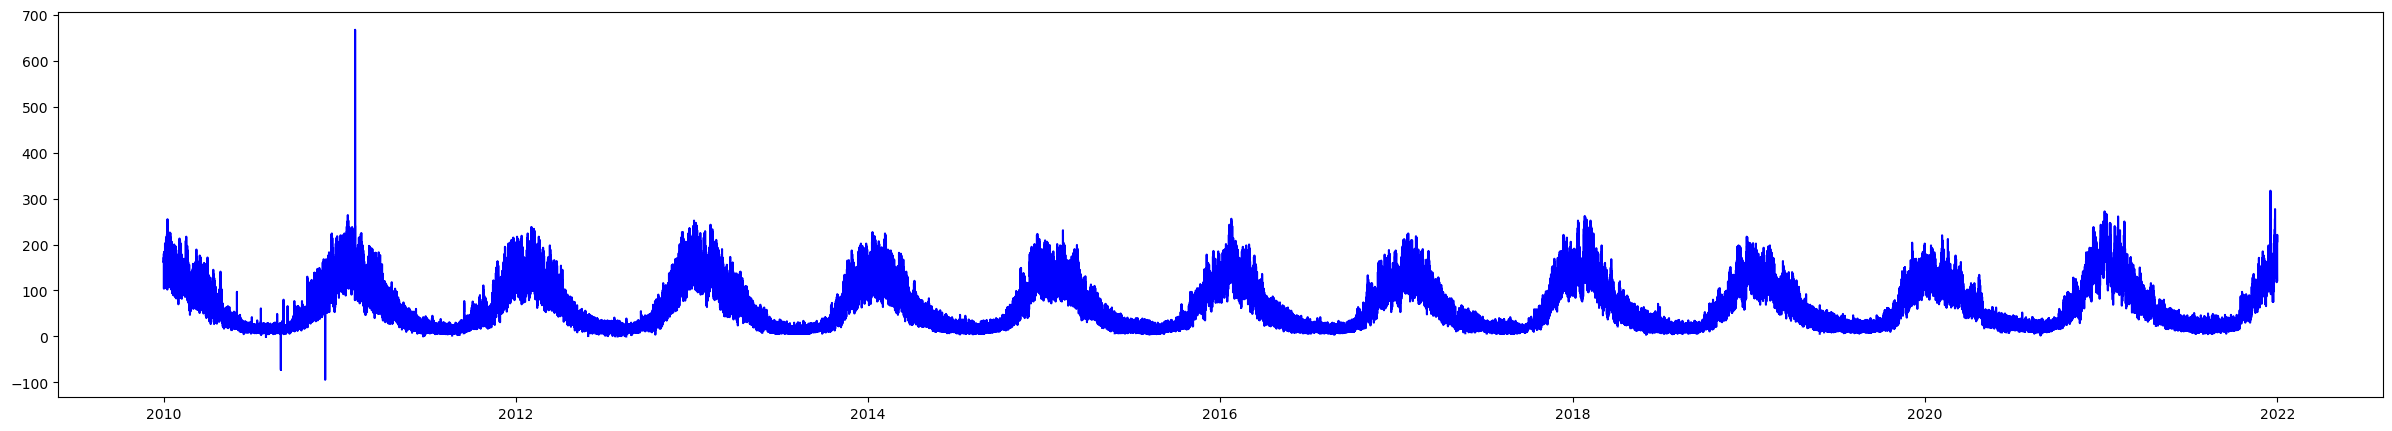

In [17]:
## 시각화
fig, ax1 = plt.subplots(figsize=(30,5))
ax1.plot(date, df_raw['CHEONGJU'], color='blue')
plt.show()

### 01-04-02. Remove Outlier (IQR)

In [18]:
## 이상치 기준 생성
## Q3 : 100개의 데이터로 가정 시, 25번째로 높은 값에 해당
## Q1 : 100개의 데이터로 가정 시, 75번째로 높은 값에 해당
## IQR : Q3 - Q1의 차이를 의미
## 이상치 : Q3 + 1.5 * IQR보다 높거나 Q1 - 1.5 * IQR보다 낮은 값을 의미
col_tar = 'CHEONGJU'
find_outlier_Usages(df_raw, col_tar)
del_outlier_Usages(df_raw, col_tar)

===============  IQR Range =============== 
338.0
149.0
126.0
nan
23.0
-166.0
===============  IQR Range =============== 
cnt_outlier = 7
===============  IQR Range =============== 
338.0
149.0
126.0
nan
23.0
-166.0
===============  IQR Range =============== 
cnt_outlier = 7
7


,METER_DATE,day_of_the_week,YEAR,MONTH,DAY,HOUR,MINUTE,code_day_of_the_week,dist_from_holiday,rest_YN,...,wind_direction,pressure_vapor,pressure_area,pressure_sea,sunshine,solar_radiation,cloud_total,cloud_midlow,visual_range,CHEONGJU
0,2010-01-01 01:00:00,Friday,2010,1,1,1,0,4,23,0,...,250.0000000000,1.6000000000,1016.4000000000,1023.8000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,178.0000000000
1,2010-01-01 02:00:00,Friday,2010,1,1,2,0,4,22,0,...,340.0000000000,1.8000000000,1016.6000000000,1024.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,170.0000000000
2,2010-01-01 03:00:00,Friday,2010,1,1,3,0,4,21,0,...,0.0000000000,1.8000000000,1016.9000000000,1024.3000000000,0.0000000000,0.0000000000,7.0000000000,7.0000000000,1800.0000000000,165.0000000000
3,2010-01-01 04:00:00,Friday,2010,1,1,4,0,4,20,0,...,340.0000000000,1.9000000000,1016.5000000000,1023.9000000000,0.0000000000,0.0000000000,2.0000000000,2.0000000000,1800.0000000000,161.0000000000
4,2010-01-01 05:00:00,Friday,2010,1,1,5,0,4,19,0,...,0.0000000000,1.9000000000,1016.2000000000,1023.7000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,1800.0000000000,162.0000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127067,2023-12-30 20:00:00,Saturday,2023,12,30,20,0,5,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127068,2023-12-30 21:00:00,Saturday,2023,12,30,21,0,5,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127069,2023-12-30 22:00:00,Saturday,2023,12,30,22,0,5,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127070,2023-12-30 23:00:00,Saturday,2023,12,30,23,0,5,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 01-04-03. Visualization (2차)

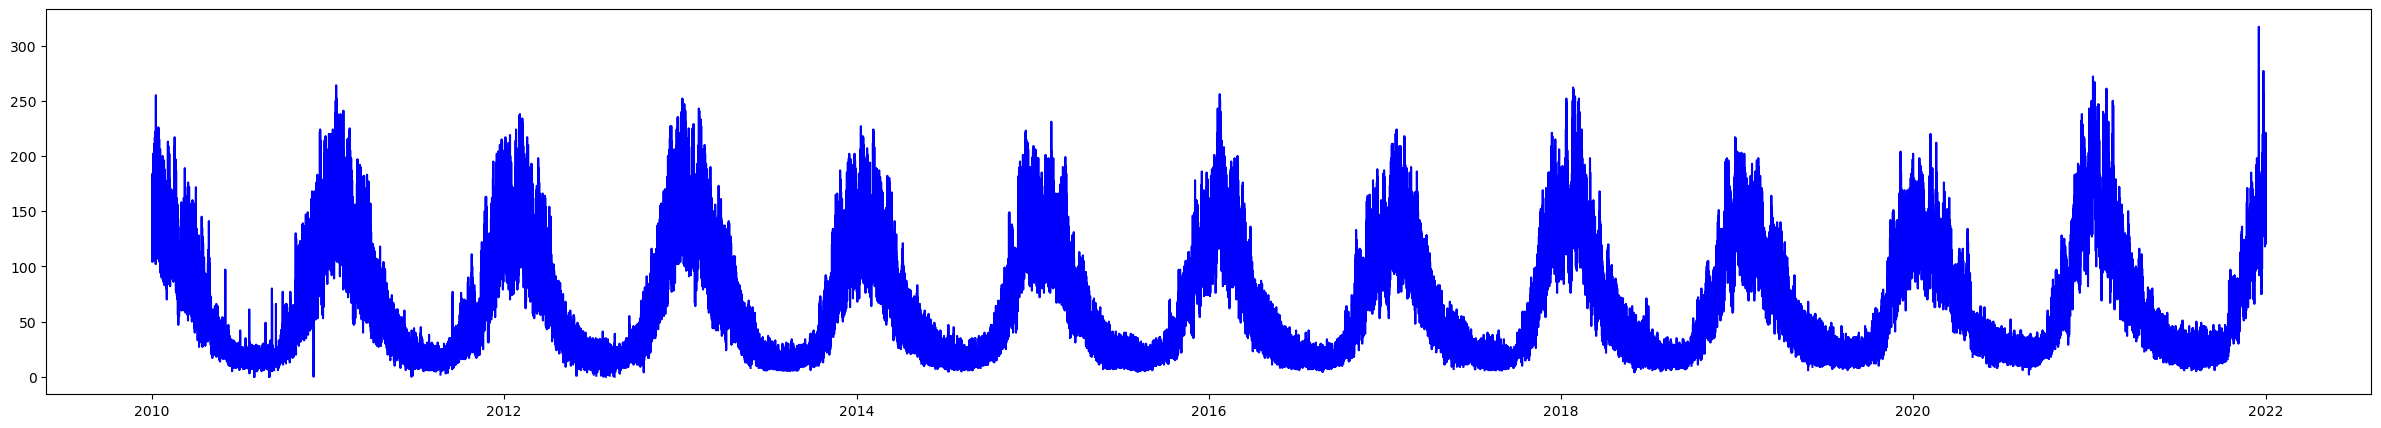

In [19]:
## 시각화
fig, ax1 = plt.subplots(figsize=(30,5))
ax1.plot(date, df_raw['CHEONGJU'], color='blue')
plt.show()

### 01-04-04. 변수형 정리

In [20]:
df_raw_temp = pd.DataFrame(df_raw)
df_raw_temp['METER_DATE'] = pd.to_datetime(df_raw_temp['METER_DATE'])

for i in range(0, len(df_raw_temp)):
    ## 중간에 Code화 되지 않은 rest_YN Data가 있다.
    if((str(df_raw_temp['rest_YN'].iloc[i]) == 'N') | (df_raw_temp['rest_YN'].iloc[i] == '0')):
        df_raw_temp['rest_YN'].iloc[i] = 0
    if((str(df_raw_temp['rest_YN'].iloc[i]) == 'Y') | (df_raw_temp['rest_YN'].iloc[i] == '1')):
        df_raw_temp['rest_YN'].iloc[i] = 1

    ## 중간에 이상하게 처리된 KASI Data가 있다.
    if((str(df_raw_temp['dist_from_holiday'].iloc[i]) == '제헌절')
        | (str(df_raw_temp['dist_from_holiday'].iloc[i]) == '한글날')):
        df_raw_temp['dist_from_holiday'].iloc[i] = 0
    
df_raw_temp['rest_YN'] = pd.to_numeric(df_raw_temp['rest_YN'])
df_raw_temp['rest_YN'] = df_raw_temp['rest_YN'].apply(pd.to_numeric)
# df_raw_temp['rest_YN'] = df_raw_temp['rest_YN'].astype('int32')
df_raw_temp['dist_from_holiday'] = df_raw_temp['dist_from_holiday'].apply(pd.to_numeric)
# df_raw_temp['dist_from_holiday'] = df_raw_temp['dist_from_holiday'].astype("int64")

In [21]:
print(df_raw_temp.columns)
print(df_raw_temp.info())

df_raw_temp = df_raw_temp.dropna()

print(df_raw_temp.info())

Index(['METER_DATE', 'day_of_the_week', 'YEAR', 'MONTH', 'DAY', 'HOUR',
       'MINUTE', 'code_day_of_the_week', 'dist_from_holiday', 'rest_YN',
       'temp_outdoor', 'temp_dew_point', 'temp_ground', 'humidity', 'rainfall',
       'snowfall', 'snowfall_3hr', 'wind_speed', 'wind_direction',
       'pressure_vapor', 'pressure_area', 'pressure_sea', 'sunshine',
       'solar_radiation', 'cloud_total', 'cloud_midlow', 'visual_range',
       'CHEONGJU'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 127072 entries, 0 to 127071
Data columns (total 28 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   METER_DATE            127072 non-null  datetime64[ns]
 1   day_of_the_week       127072 non-null  object        
 2   YEAR                  127072 non-null  int64         
 3   MONTH                 127072 non-null  int64         
 4   DAY                   127072 non-null  int64         

In [22]:
## 1) Train 전 오류
## ValueError: DataFrame.dtypes for data must be int, float or bool.
## Did not expect the data types in the following fields: DHW_METER_DATE, day_of_the_week, name_of_holiday
## 형식에 맞지 않는 열이 앞의 Preprocessing 단계에서 제거되어야 함.
## 2) Train 중 오류
## ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type Timestamp).
## 1차
# df_raw_temp = df_raw_temp[['YEAR', 'MONTH', 'DAY', 'code_day_of_the_week', 'dist_from_holiday', 'rest_YN'
#                            , 'HOUR'
#                            , 'temp_outdoor', 'temp_dew_point', 'temp_ground'
#                            , 'humidity'
#                            , 'rainfall', 'snowfall', 'snowfall_3hr'
#                            , 'wind_speed', 'wind_direction'
#                            , 'pressure_vapor', 'pressure_area', 'pressure_sea'
#                            , 'sunshine'
#                            , 'solar_radiation'
#                            , 'cloud_total', 'cloud_midlow', 'visual_range'
#                            , 'CHEONGJU']]

## 2차 YD, Dist 제거
# df_raw_temp = df_raw_temp[['MONTH', 'code_day_of_the_week', 'rest_YN'
#                            , 'HOUR'
#                            , 'temp_outdoor', 'temp_dew_point', 'temp_ground'
#                            , 'humidity'
#                            , 'rainfall', 'snowfall', 'snowfall_3hr'
#                            , 'wind_speed', 'wind_direction'
#                            , 'pressure_vapor', 'pressure_area', 'pressure_sea'
#                            , 'sunshine'
#                            , 'solar_radiation'
#                            , 'cloud_total', 'cloud_midlow', 'visual_range'
#                            , 'CHEONGJU']]

## 3차 YD, Code_day_of_the_week 제거
df_raw_temp = df_raw_temp[['MONTH', 'dist_from_holiday', 'rest_YN'
                           , 'HOUR'
                           , 'temp_outdoor', 'temp_dew_point', 'temp_ground'
                           , 'humidity'
                           , 'rainfall', 'snowfall', 'snowfall_3hr'
                           , 'wind_speed', 'wind_direction'
                           , 'pressure_vapor', 'pressure_area', 'pressure_sea'
                           , 'sunshine'
                           , 'solar_radiation'
                           , 'cloud_total', 'cloud_midlow', 'visual_range'
                           , 'CHEONGJU']]
df_raw_temp.isnull().sum()

MONTH                0
dist_from_holiday    0
rest_YN              0
HOUR                 0
temp_outdoor         0
temp_dew_point       0
temp_ground          0
humidity             0
rainfall             0
snowfall             0
snowfall_3hr         0
wind_speed           0
wind_direction       0
pressure_vapor       0
pressure_area        0
pressure_sea         0
sunshine             0
solar_radiation      0
cloud_total          0
cloud_midlow         0
visual_range         0
CHEONGJU             0
dtype: int64

## 01-05. Data Split (By Weekdays)

In [23]:
df_WD = df_raw_temp[df_raw_temp['rest_YN'] == 0]

df_WE = df_raw_temp[df_raw_temp['rest_YN'] == 1]

## 01-05. Data Analysis

### 01-05-01. Correlation

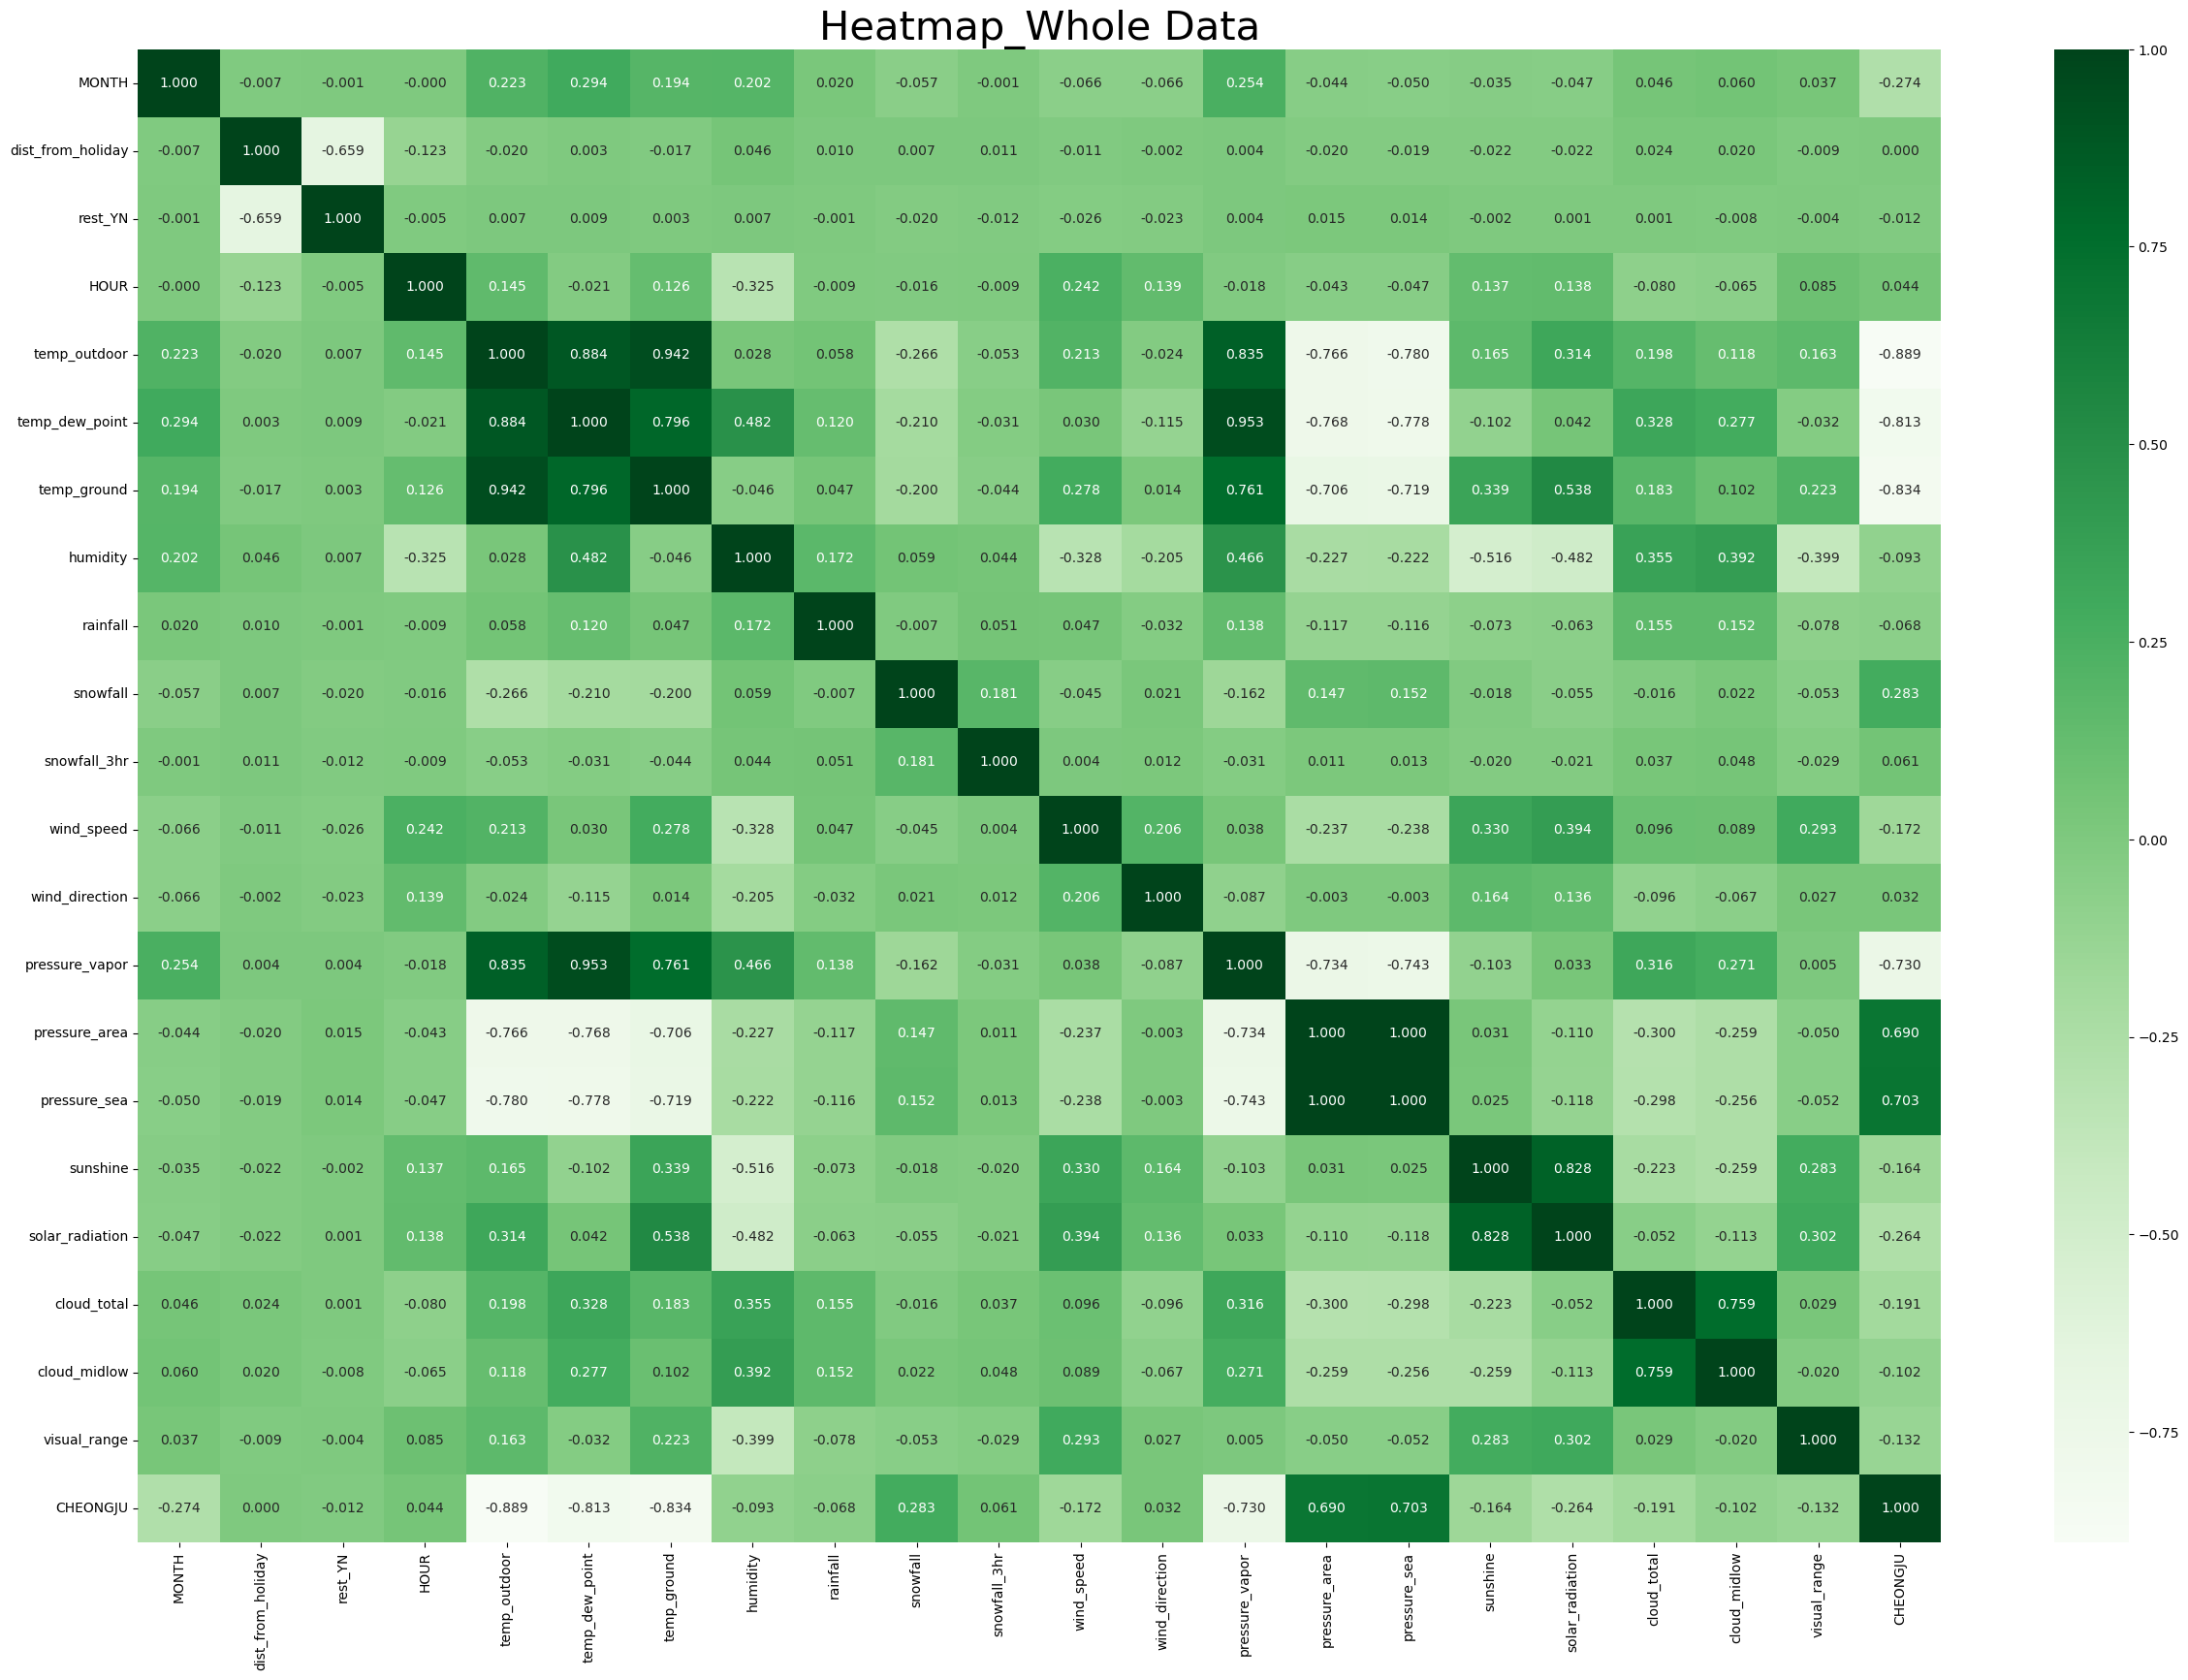

In [24]:
## 상관관계 분석
## 상관관계 변수 생성
df_corr = df_raw_temp.corr()
# df_corr.corr()

## Heatmap 분석
plt.figure(figsize=(30,20))
ax = sns.heatmap(df_corr, annot=True, fmt='.3f', cmap='Greens')
plt.title("Heatmap_Whole Data", fontsize=30)
plt.show()

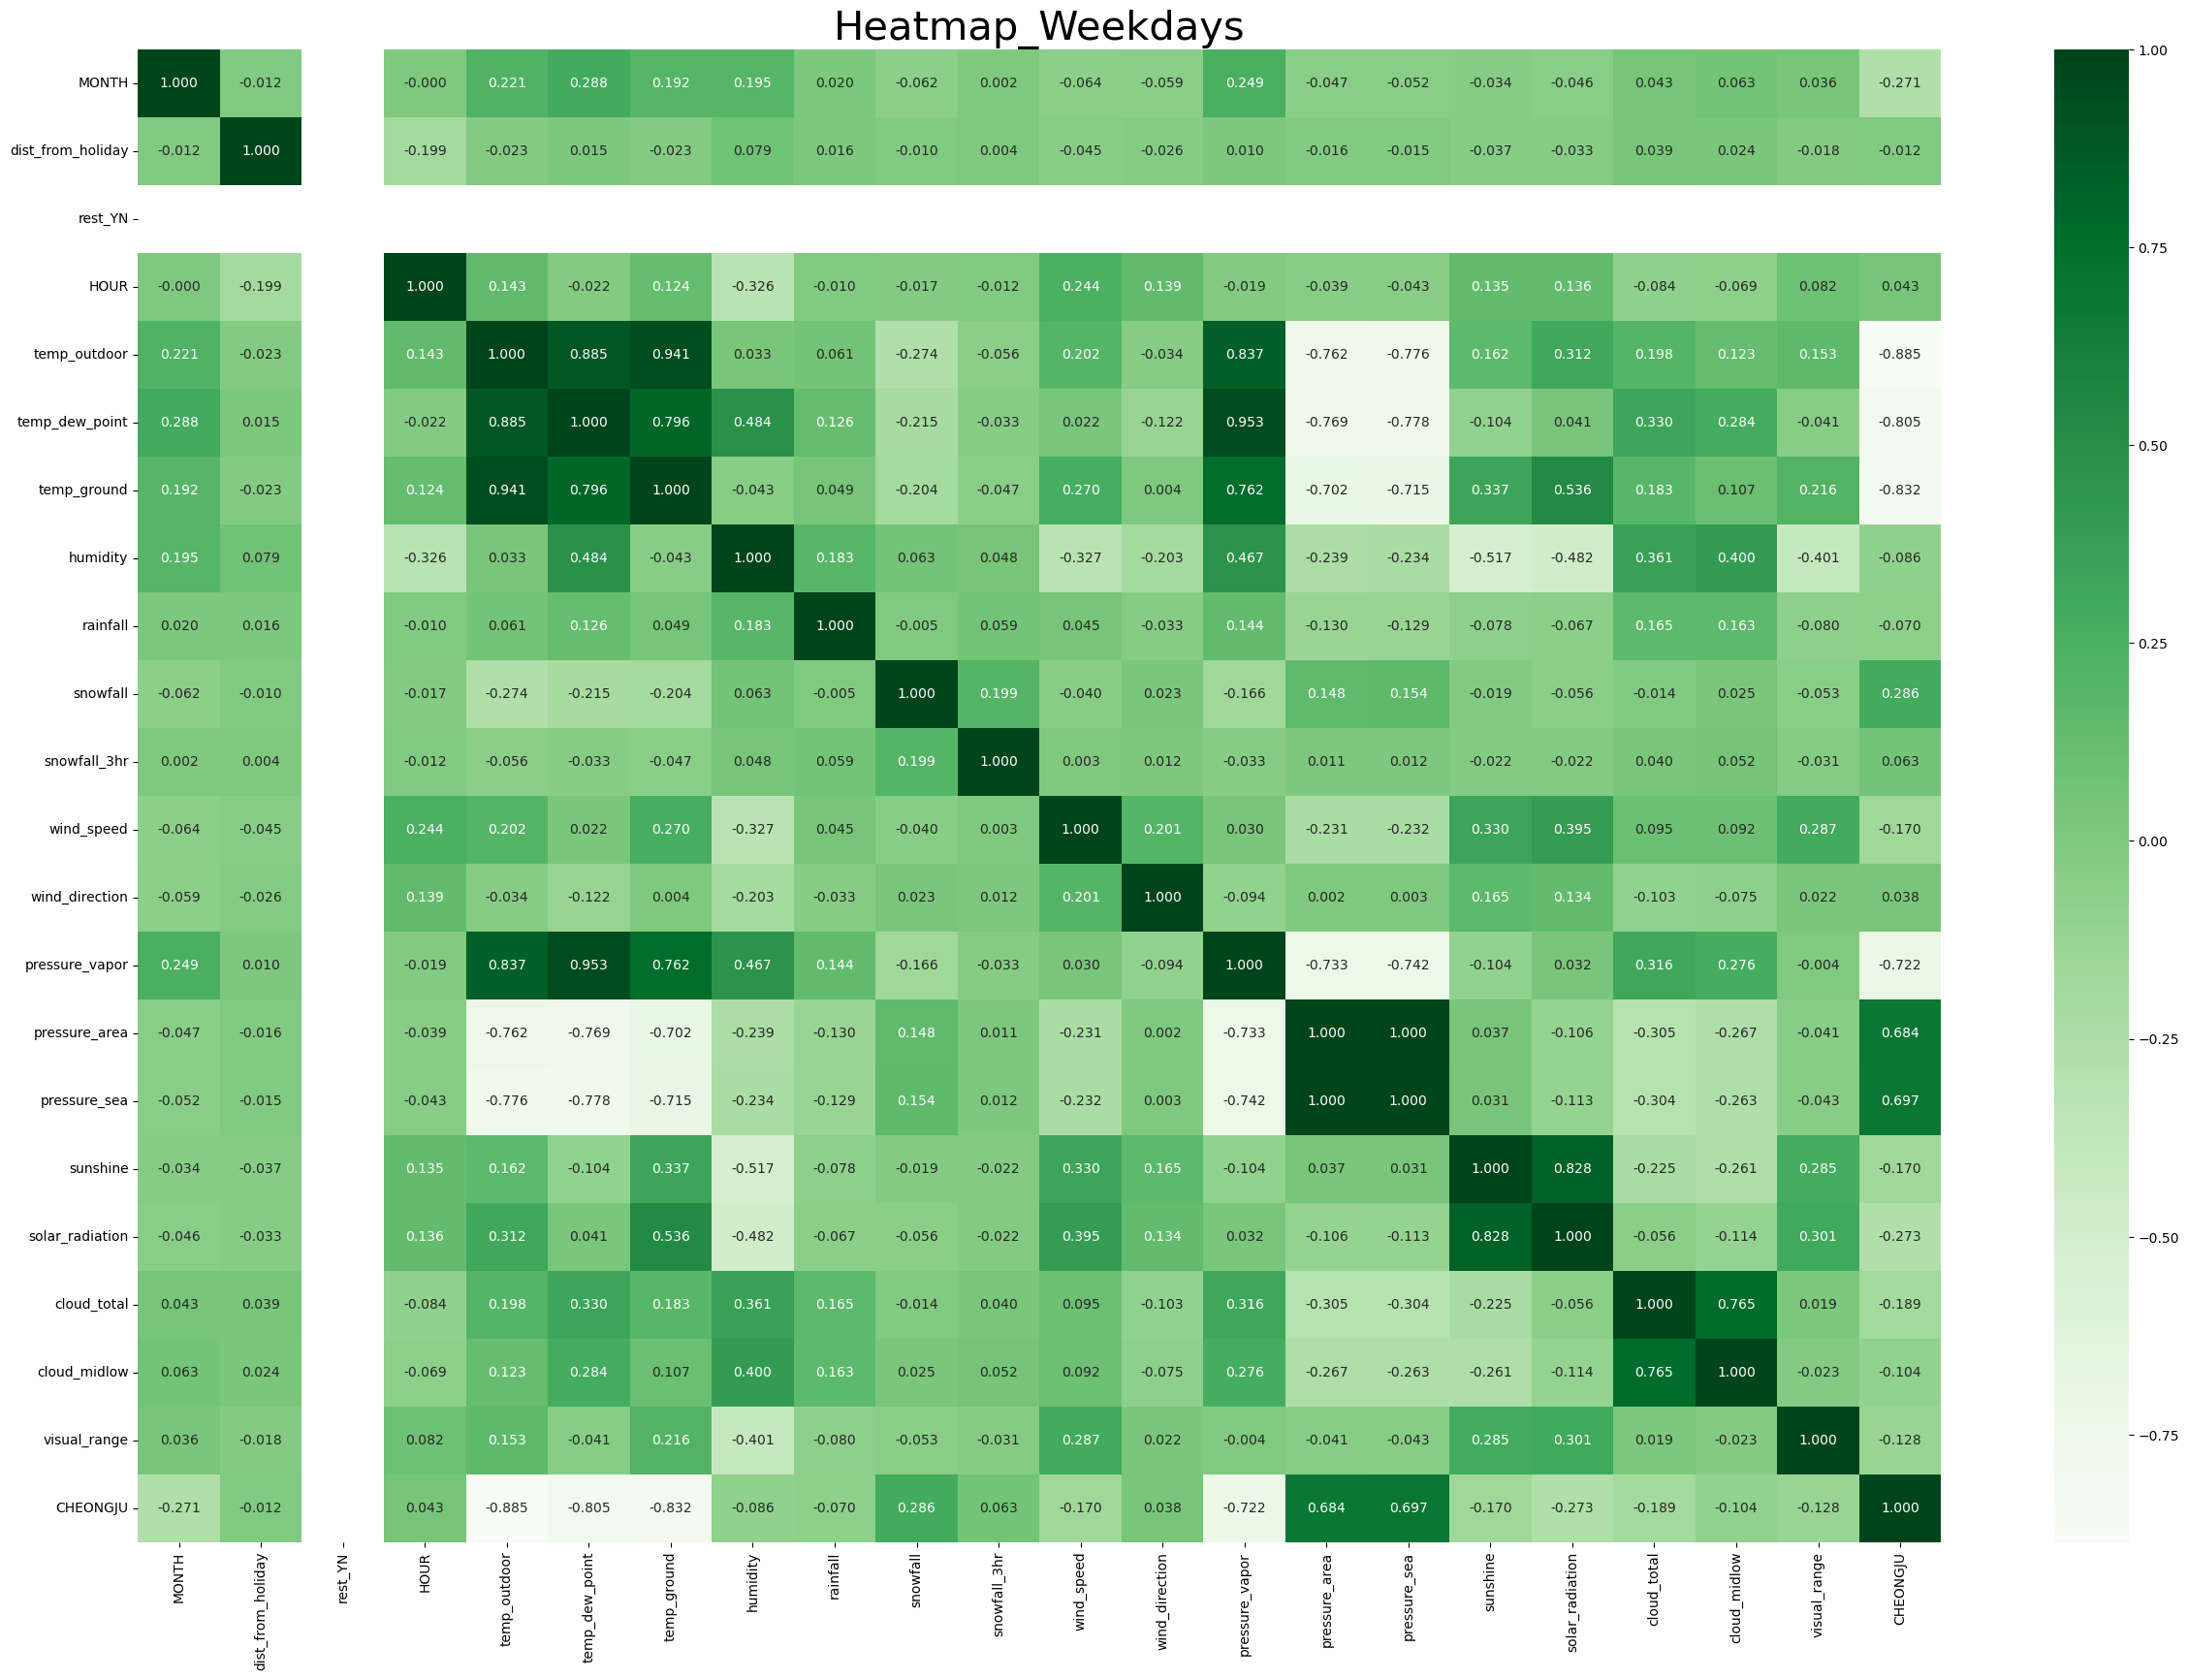

In [25]:
## 상관관계 분석
## 상관관계 변수 생성
df_corr = df_WD.corr()
# df_corr.corr()

## Heatmap 분석
plt.figure(figsize=(30,20))
ax = sns.heatmap(df_corr, annot=True, fmt='.3f', cmap='Greens')
plt.title("Heatmap_Weekdays", fontsize=30)
plt.show()

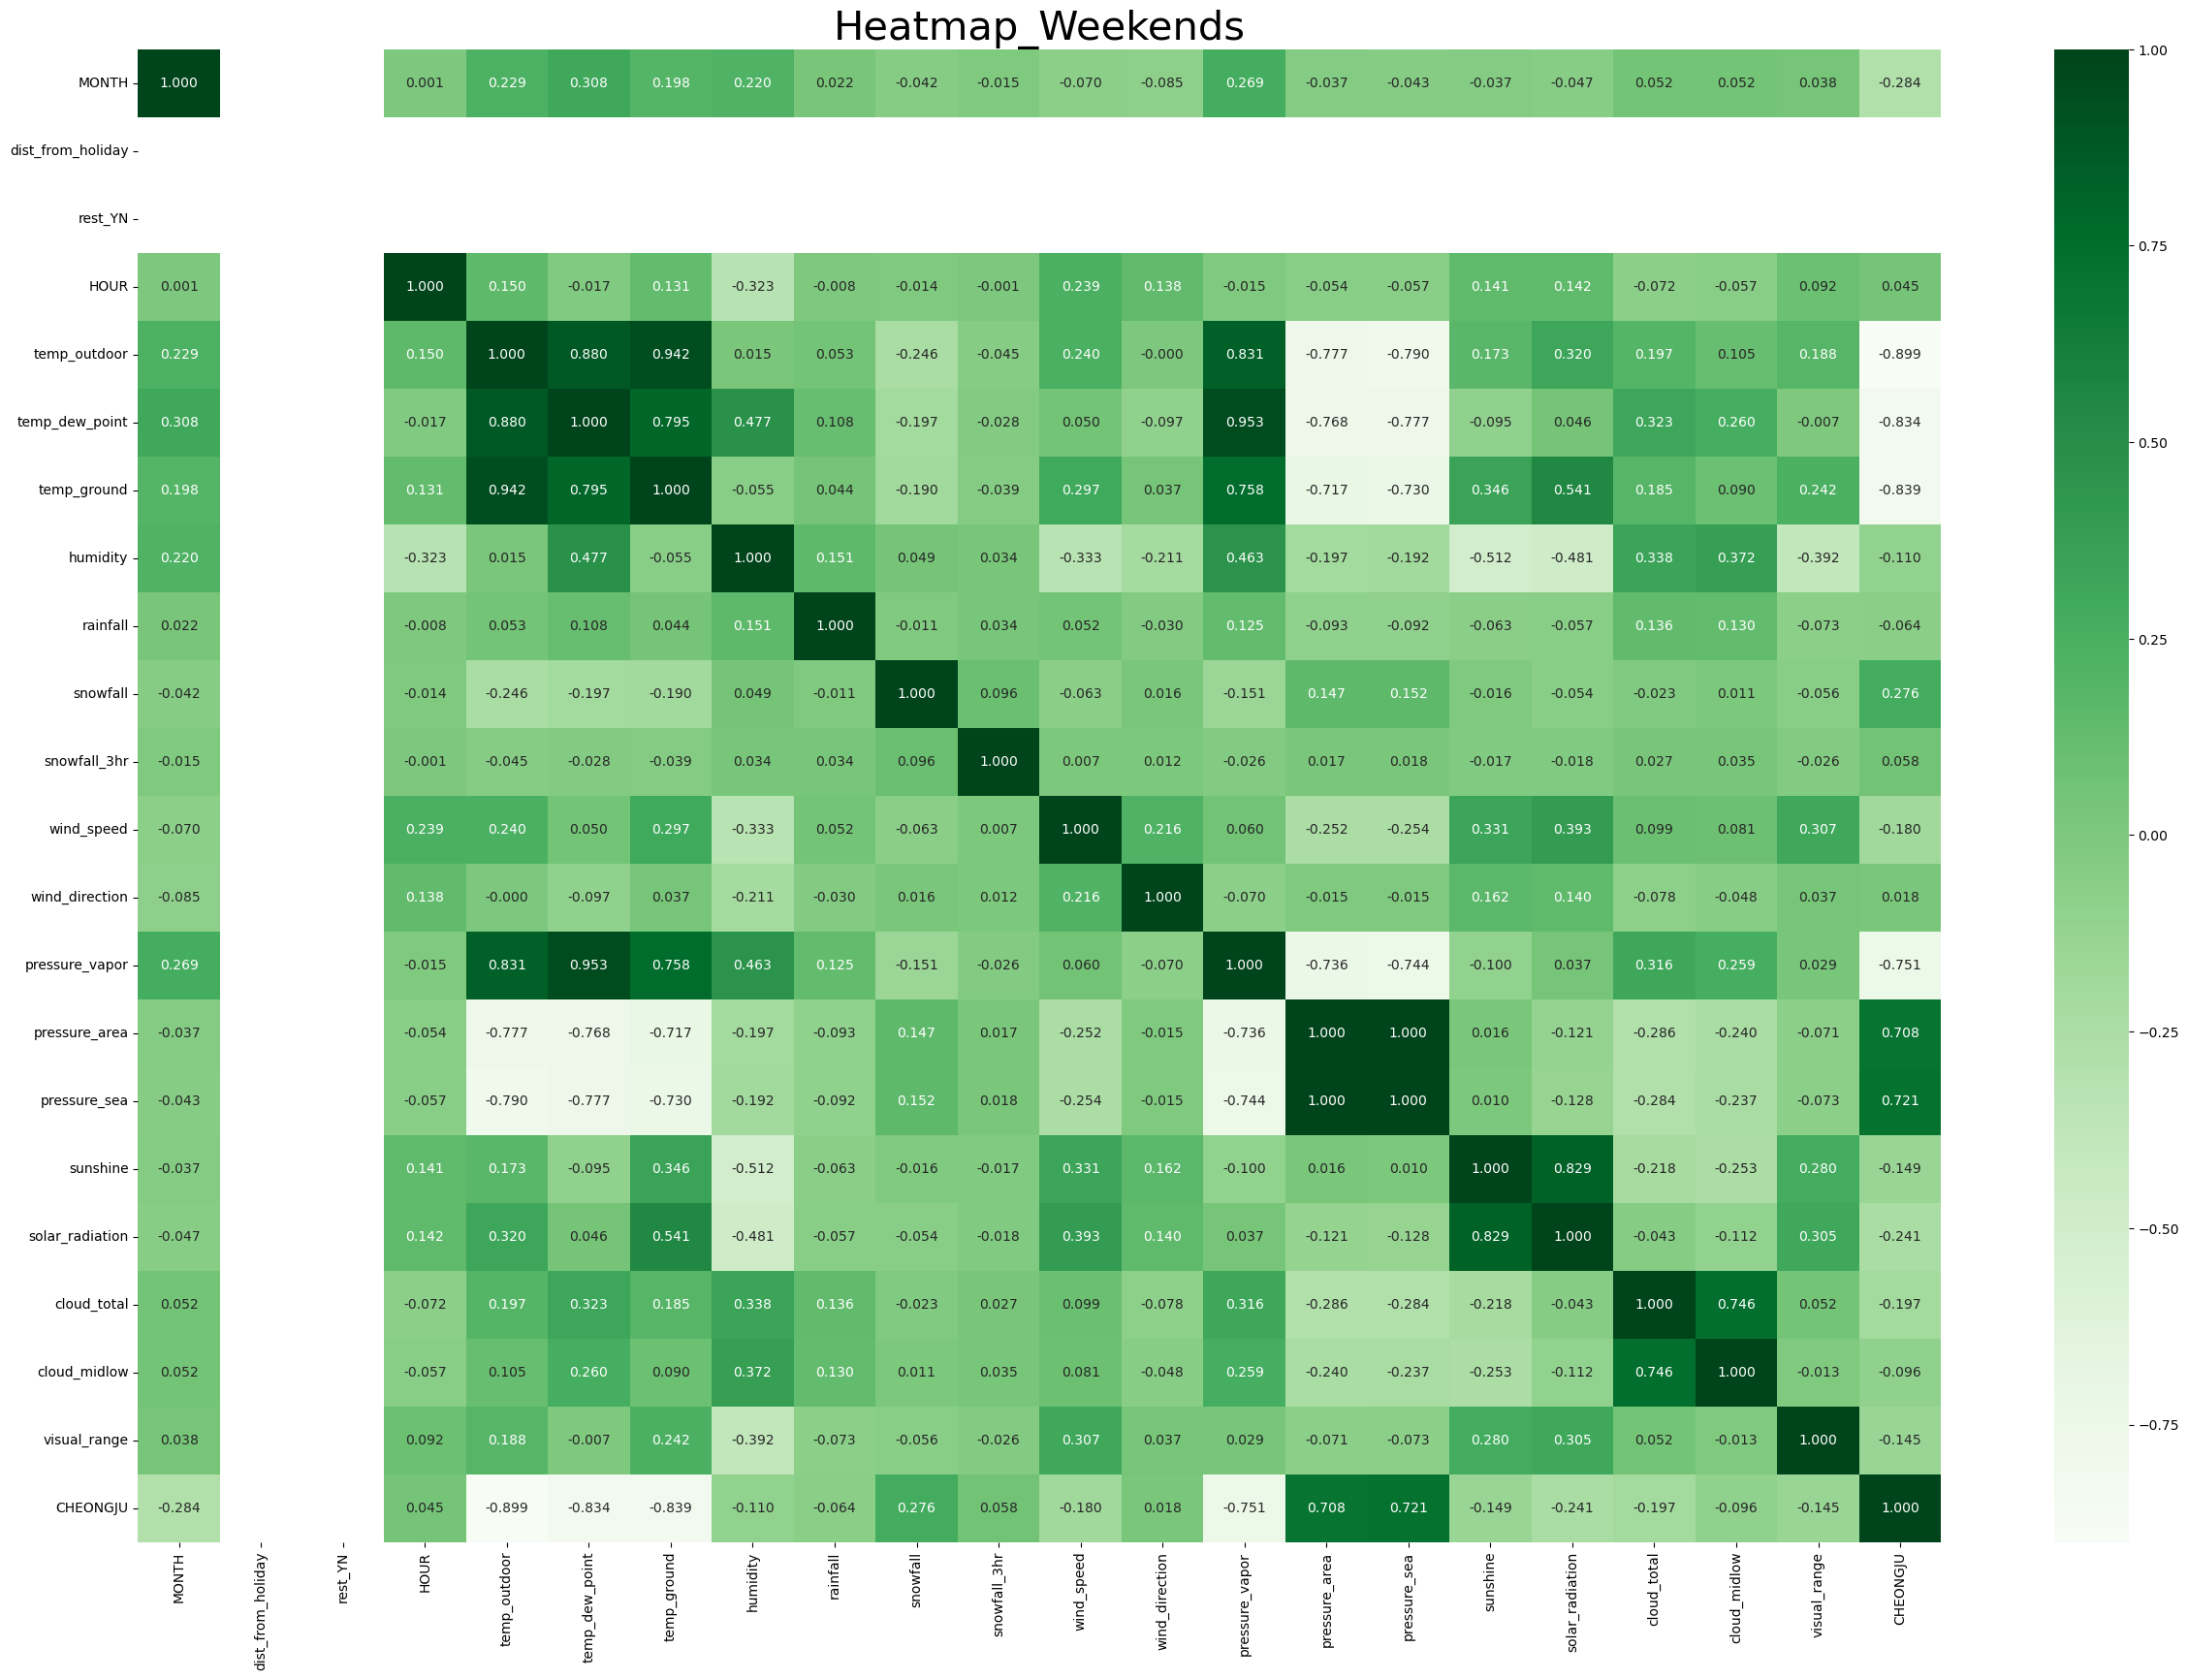

In [26]:
## 상관관계 분석
## 상관관계 변수 생성
df_corr = df_WE.corr()
# df_corr.corr()

## Heatmap 분석
plt.figure(figsize=(30,20))
ax = sns.heatmap(df_corr, annot=True, fmt='.3f', cmap='Greens')
plt.title("Heatmap_Weekends", fontsize=30)
plt.show()

## 01-06. Data Split (Train/Test Setting)

In [47]:
## 전체 유형
df_raw = df_raw_temp
## 평일일 때만
# df_raw = df_WD
## 휴일일 때만
# df_raw = df_WE

trainSet_Origin, testSet_Origin = train_test_split(df_raw, test_size=0.3, shuffle=False)
print(trainSet_Origin.shape, testSet_Origin.shape)

(73633, 22) (31558, 22)


In [48]:
trainSet = trainSet_Origin
testSet = testSet_Origin

## Input / Target Split
trainXX = trainSet.drop(['CHEONGJU'],axis=1)
trainYY = trainSet[['CHEONGJU']]
#valX = val.drop(['INST_F'],axis=1)
#valY = val[['INST_F']]
testXX = testSet.drop(['CHEONGJU'],axis=1)
testYY = testSet[['CHEONGJU']]

In [49]:
trainXXindex = trainXX.index
trainXXcolumns = trainXX.columns

trainYYindex = trainYY.index
trainYYcolumns = trainYY.columns

testXXindex = testXX.index
testXXcolumns = testXX.columns

testYYindex = testYY.index
testYYcolumns = testYY.columns

#valXindex = valX.index
#valYindex = valY.index

#valXcolumns = valX.columns
#valYcolumns = valY.columns

In [50]:
d_trainXX=pd.DataFrame(trainXX, index=trainXXindex, columns=trainXXcolumns)
# d_trainXX=pd.DataFrame(trainXX, index=trainXXindex, columns=trainXXcolumns)
d_trainYY=trainYY

#d_valX=pd.DataFrame(func_valSet, index=valXindex, columns=valXcolumns)
#d_valY=valY

d_testXX=pd.DataFrame(testXX, index=testXXindex, columns=testXXcolumns)
# d_testXX=pd.DataFrame(trainXX, index=testXXindex, columns=testXXcolumns)
d_testYY=testYY

## 01-07. ML (XGBoost)


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

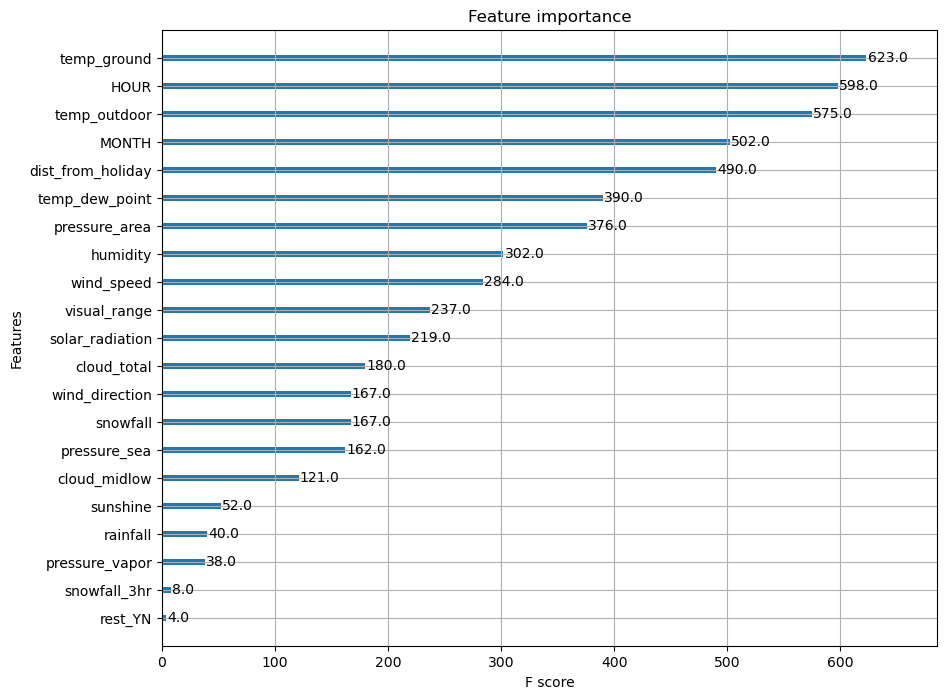

In [51]:
XGB_CJ = xgb.XGBRegressor(n_estimators = 1000)
XGB_CJ.fit(d_trainXX, d_trainYY
           , eval_set=[(d_testXX, d_testYY)]
           , early_stopping_rounds = 50, verbose = False)

## 주요 변수 판단
plot_importance(XGB_CJ)

In [52]:
XGB_pred = XGB_CJ.predict(d_testXX)
XGB_pred = np.reshape(XGB_pred,(-1,1))

In [53]:
d_actual = testYY.to_numpy()
d_actual = np.reshape(d_actual,(-1,1))

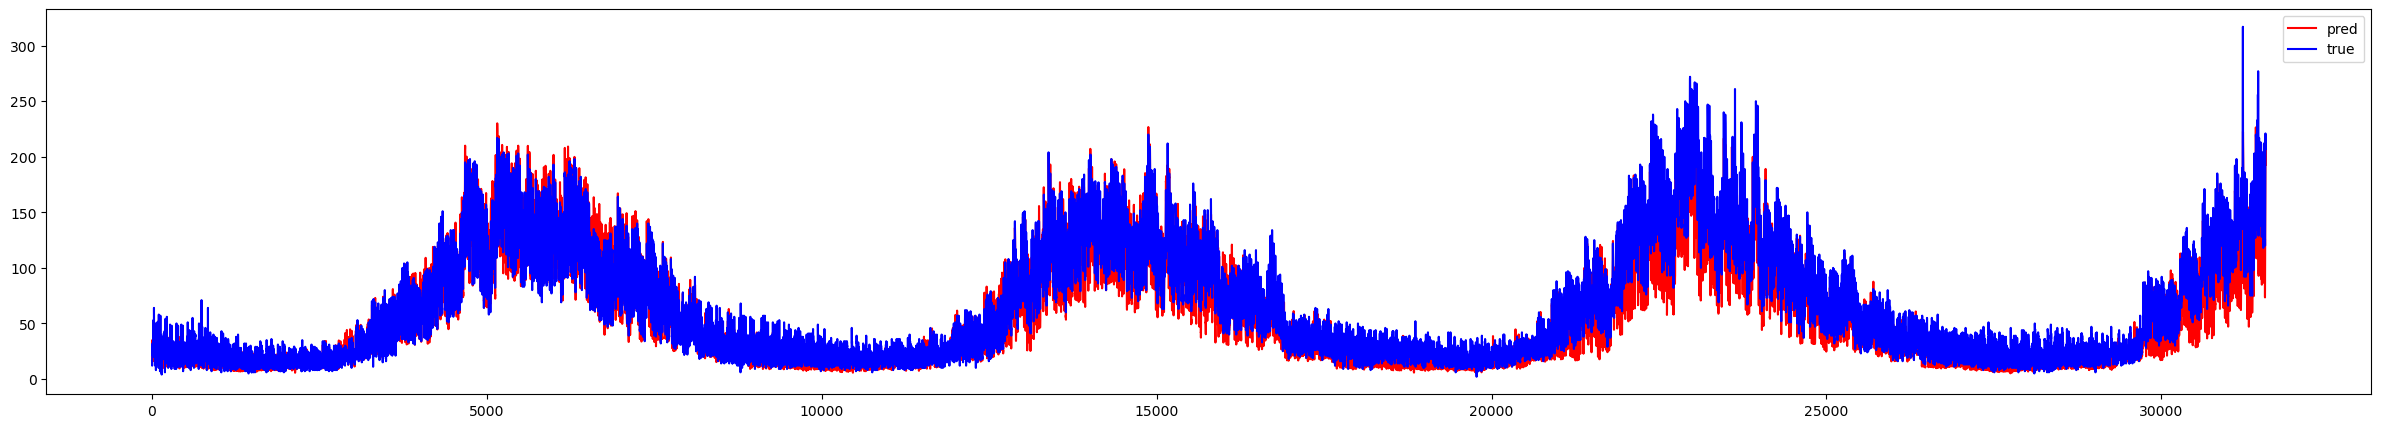

In [54]:
plt.figure(figsize=(30,5))
plt.plot(XGB_pred,color='red',label='pred')
plt.plot(d_actual,color='blue',label='true')
plt.legend()
plt.show()

In [55]:
from sklearn.metrics import mean_absolute_percentage_error
print('mean_absolute_percentage_error : ', mean_absolute_percentage_error(d_actual, XGB_pred))

from sklearn.metrics import mean_absolute_error
print('mean_absolute_error : ', mean_absolute_error(d_actual, XGB_pred))                                      

from sklearn.metrics import mean_squared_error
print('mean_squared_error : ', mean_squared_error(d_actual, XGB_pred))

from sklearn.metrics import r2_score   # model.score
print('r2_score : ', r2_score(d_actual, XGB_pred))

mean_absolute_percentage_error :  0.1706969005407645
mean_absolute_error :  8.912523228433605
mean_squared_error :  154.89378164197183
r2_score :  0.9410536740642665


In [56]:
print(trainSet.shape)
print(testSet.shape)

(73633, 22)
(31558, 22)
